In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from inference.moment_inference import MomentInference
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun  
from joblib import delayed,Parallel
from scipy.stats import spearmanr

In [3]:
import swifter

In [4]:
print(np.__version__)

1.19.2


# Autosomal Random Monoallelic Expression (aRME) is explained by transcriptional bursting

Given the parameters inferred in Larsson et. al. we can calculate the probability of allele expressing a given gene or not at the time of sampling. We will define a function here which calculates the probability of observing $k$ UMI counts for an allele of gene $g$ given the parameters, $$P_g(K = k | k_{on}, k_{off}, k_{syn}).$$

In [5]:
def dBP_dict(at, alpha, bet, lam):
    at_ = np.copy(at)
    at_.shape = (len(at_), 1)
    np.repeat(at_, 40, axis = 1)
    def fun(at_, m):
        if(max(m) < 1e6):
            return(poisson.pmf(at_,m))
        else:
            return(norm.pdf(at_,loc=m,scale=sqrt(m)))
    x,w = j_roots(40,alpha = bet - 1, beta = alpha - 1)
    gs = np.sum(w*fun(at_, m = lam*(1+x)/2), axis=1)
    prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
    return {k: v for k, v in zip(at.tolist(), prob.tolist())}

In [7]:
def sim_beta_poisson(kon,koff,ksyn=100, size=100):
    "Generate simulated single-cell RNA-seq data according to the two-state model and with parameters kon, koff, ksyn"
    v = beta(kon, koff, size=size)
    return poisson(v*ksyn)

In [10]:
def getProbNoExpr(params):
    kon = params[0]
    koff = params[1]
    ksyn = params[2]
    return dBP_dict(np.array([0]),kon,koff,ksyn)[0]

In [11]:
UMI = pd.read_csv('data/F1_ref/umiSplit_c57.qc.csv', index_col=0)
params = pd.read_csv('data/F1_ref/umiSplit_c57.qc.maxl.ci.wfilt1.csv', index_col=0, header=None)

In [12]:
UMI_cast = pd.read_csv('data/F1_ref/umiSplit_cast.qc.csv', index_col=0)
params_cast = pd.read_csv('data/F1_ref/umiSplit_cast.qc.maxl.ci.wfilt1.csv', index_col=0, header=None)

In [13]:
df_readspercell_plate3 = pd.read_csv('data/Fibro_plate3.readspercell.txt', sep='\t').groupby('RG').sum()
df_readspercell_plate4 = pd.read_csv('data/Fibro_plate4.readspercell.txt', sep='\t').groupby('RG').sum()

df_readspercell = df_readspercell_plate3.append(df_readspercell_plate4)

In [14]:
df_UMIspercell_plate3 = pd.read_csv('data/Fibro_plate3.UMIcounts.txt', sep='\t', index_col=1)
df_UMIspercell_plate3 = df_UMIspercell_plate3[df_UMIspercell_plate3['type'] == 'Exon']
df_UMIspercell_plate4 = pd.read_csv('data/Fibro_plate4.UMIcounts.txt', sep='\t', index_col=1)
df_UMIspercell_plate4 = df_UMIspercell_plate4[df_UMIspercell_plate4['type'] == 'Exon']
df_UMIspercell = df_UMIspercell_plate3.append(df_UMIspercell_plate4)

In [15]:
df_UMIspercell.reindex(UMI.columns).mean()

Count    206943.739003
dtype: float64

In [16]:
df_readspercell.reindex(UMI.columns).median()

N    3424143.5
dtype: float64

In [17]:
df_readspercell.reindex(UMI.columns).mean()

N    3.501895e+06
dtype: float64

In [18]:
(UMI+UMI_cast).sum().mean()

160864.12316715543

In [19]:
print('C57 genes: {}'.format(params.shape[0]))
print('CAST genes: {}'.format(params_cast.shape[0]))

C57 genes: 9337
CAST genes: 9070


In [20]:
print('C57 genes: {}'.format(UMI.shape))
print('CAST genes: {}'.format(UMI_cast.shape))

C57 genes: (23270, 682)
CAST genes: (23270, 682)


In [21]:
# find common genes
common_idx = set(params.index.values).intersection(params_cast.index.values)

UMI = UMI.loc[common_idx]
UMI_cast = UMI_cast.loc[common_idx]
params = params.loc[common_idx]
params_cast = params_cast.loc[common_idx]

In [22]:
print('C57 genes: {}'.format(params.shape[0]))
print('CAST genes: {}'.format(params_cast.shape[0]))

C57 genes: 7606
CAST genes: 7606


In [23]:
import warnings
warnings.filterwarnings('ignore')

Calculate goodness of fit on both alleles

## Calculating aRME probabilities
With the resulting genes we can calculate the probabilities of an allele of the genes not being observed, i.e. 
$$ p_{g_{c57}} = P_{g_{c57}}(K = 0 | k_{on}, k_{off}, k_{syn}). $$
and
$$ p_{g_{cast}} = P_{g_{cast}}(K = 0 | k_{on}, k_{off}, k_{syn}). $$

This allows us to calculate the probabilities of:

* Probability of expression on no allele $p_{silent} = p_{g_{c57}}*p_{g_{cast}}$.
* Probability of monoallelic expression on the c57 allele $p_{mono_{c57}} = (1-p_{g_{c57}})*p_{g_{cast}}$.
* Probability of monoallelic expression on the cast allele $p_{mono_{cast}} = p_{g_{c57}}*(1-p_{g_{cast}})$.
* Probability of biallelic expression $p_{biallelic} = (1-p_{g_{c57}})*(1-p_{g_{cast}})$.

These probabilites assume that the alleles burst independently. Given $n$ cells we can also test whether the model is consistent with our data by testing since if e.g. $B_g$ is the number of biallelic cells $B_g \in Bin(n, p_{biallelic})$.

## Calculating observations in data.

We can calculate the observed fractions of these four diferrent cases in our data as well and compare them.

In [24]:
noexprP_c57 = {}
noexprP_cast = {}
for gene in params.index.values:
    noexprP_c57[gene] = getProbNoExpr(params.loc[gene][0:3].values)
    noexprP_cast[gene] = getProbNoExpr(params_cast.loc[gene][0:3].values)

In [25]:
noexprData_c57 = {}
noexprData_cast = {}
for gene in common_idx:
    noexprData_c57[gene] = np.mean(UMI.loc[gene][pd.notnull(UMI.loc[gene])] == 0)
    noexprData_cast[gene] = np.mean(UMI_cast.loc[gene][pd.notnull(UMI_cast.loc[gene])] == 0)

In [26]:
in_c57_in_cast = {}
in_c57_not_cast = {}
in_cast_not_c57 = {}
not_c57_not_cast = {}
for gene in common_idx:
    in_c57 = UMI.loc[gene][pd.notnull(UMI.loc[gene])] != 0
    in_cast = UMI_cast.loc[gene][pd.notnull(UMI_cast.loc[gene])] != 0
    in_c57_in_cast[gene] = np.mean(in_cast&in_c57)
    in_cast_not_c57[gene] = np.mean(in_cast&(~in_c57))
    in_c57_not_cast[gene] = np.mean(in_c57&(~in_cast))
    not_c57_not_cast[gene] = np.mean((~in_c57)&(~in_cast))

In [27]:
expr_df = pd.DataFrame([noexprData_c57, noexprData_cast, in_c57_in_cast, in_cast_not_c57, in_c57_not_cast, not_c57_not_cast, noexprP_c57, noexprP_cast], index=['silent_c57', 'silent_cast', 'biallelic','mono_cast','mono_c57', 'silent', 'p_silent_c57','p_silent_cast']).T

In [28]:
expr_df['p_silent'] = expr_df['p_silent_c57']*expr_df['p_silent_cast']
expr_df['p_biallelic'] = (1-expr_df['p_silent_c57'])*(1-expr_df['p_silent_cast'])
expr_df['p_mono_cast']  = expr_df['p_silent_c57']*(1-expr_df['p_silent_cast'])
expr_df['p_mono_c57'] = (1-expr_df['p_silent_c57'])*expr_df['p_silent_cast']

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
def get_correlations(UMI, UMI_cast):
    train, test = train_test_split(UMI.T, test_size=0.5, random_state=1808362)
    train_cast = UMI_cast.reindex(train.index,axis=1)
    test_cast = UMI_cast.reindex(test.index,axis=1)
    train = train.T
    test = test.T
    moment_params = train.apply(lambda row: MomentInference(row.dropna()),axis=1)
    moment_params_cast = train_cast.apply(lambda row: MomentInference(row.dropna()),axis=1)
    pass_inference = (1-(moment_params.apply(lambda row: any(row < 1e-4)) | moment_params_cast.apply(lambda row: any(row < 1e-4))).astype(int)).astype(bool)
    pass_index = pass_inference[pass_inference].index
    moment_params = moment_params.loc[pass_index]
    train_cast = train_cast.loc[pass_index]
    test = test.loc[pass_index]
    test_cast = test_cast.loc[pass_index]
    noexprP_c57 = {}
    noexprP_cast = {}
    for gene in pass_index:
        noexprP_c57[gene] = getProbNoExpr(moment_params[gene])
        noexprP_cast[gene] = getProbNoExpr(moment_params_cast[gene])

    noexprData_c57 = {}
    noexprData_cast = {}
    for gene in pass_index:
        noexprData_c57[gene] = np.mean(test.loc[gene][pd.notnull(test.loc[gene])] == 0)
        noexprData_cast[gene] = np.mean(test_cast.loc[gene][pd.notnull(test_cast.loc[gene])] == 0)
    in_c57_in_cast = {}
    in_c57_not_cast = {}
    in_cast_not_c57 = {}
    not_c57_not_cast = {}
    for gene in pass_index:
        in_c57 = test.loc[gene][pd.notnull(test.loc[gene])] != 0
        in_cast = test_cast.loc[gene][pd.notnull(test_cast.loc[gene])] != 0
        in_c57_in_cast[gene] = np.mean(in_cast&in_c57)
        in_cast_not_c57[gene] = np.mean(in_cast&(~in_c57))
        in_c57_not_cast[gene] = np.mean(in_c57&(~in_cast))
        not_c57_not_cast[gene] = np.mean((~in_c57)&(~in_cast))
    expr_df = pd.DataFrame([noexprData_c57, noexprData_cast, in_c57_in_cast, in_cast_not_c57, in_c57_not_cast, not_c57_not_cast, noexprP_c57, noexprP_cast], index=['silent_c57', 'silent_cast', 'biallelic','mono_cast','mono_c57', 'silent', 'p_silent_c57','p_silent_cast']).T
    expr_df['p_silent'] = expr_df['p_silent_c57']*expr_df['p_silent_cast']
    expr_df['p_biallelic'] = (1-expr_df['p_silent_c57'])*(1-expr_df['p_silent_cast'])
    expr_df['p_mono_cast']  = expr_df['p_silent_c57']*(1-expr_df['p_silent_cast'])
    expr_df['p_mono_c57'] = (1-expr_df['p_silent_c57'])*expr_df['p_silent_cast']
    expr_df = expr_df.dropna()
    fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)
    for key, color,ax in zip(['biallelic','silent','mono_cast','mono_c57'],['lightblue','gray','salmon','salmon'], iterAX(axes)):
        ax.scatter(expr_df['{}'.format(key)], expr_df['p_{}'.format(key)], s=1, c = color)
        print(key, spearmanr(expr_df['{}'.format(key)], expr_df['p_{}'.format(key)]))
    plt.tight_layout()
    plt.savefig('figures/Table_1.pdf')

    plt.show()

In [31]:
def iterAX(axes):
    for row in axes:
        for ax in row:
            yield ax

biallelic SpearmanrResult(correlation=0.9818360375610531, pvalue=0.0)
silent SpearmanrResult(correlation=0.9692454631302829, pvalue=0.0)
mono_cast SpearmanrResult(correlation=0.8811336045607125, pvalue=0.0)
mono_c57 SpearmanrResult(correlation=0.8860985443131503, pvalue=0.0)


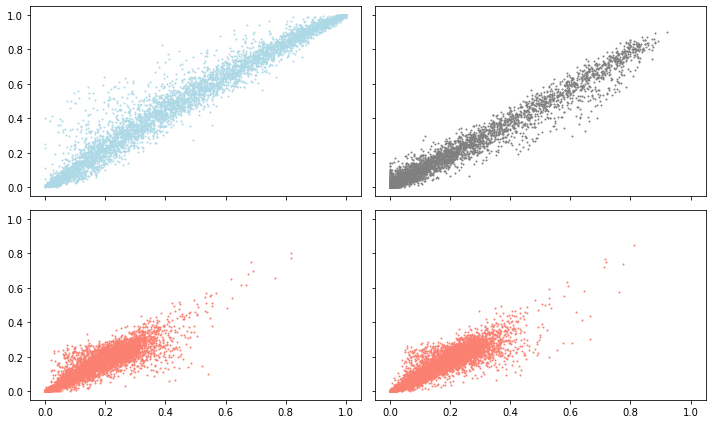

In [32]:
get_correlations(UMI, UMI_cast)

## Showing correlations between the four probabilities and observed fractions.

In [34]:
def iterAX(axes):
    for row in axes:
        for ax in row:
            yield ax

In [35]:
from scipy.stats import spearmanr

SpearmanrResult(correlation=0.9721990089638962, pvalue=0.0)


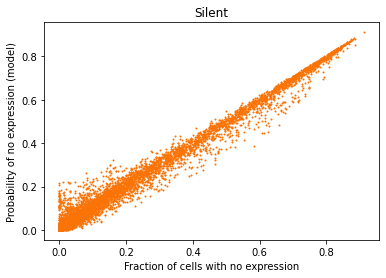

In [63]:
plt.title('Silent')
plt.scatter(expr_df['silent'], expr_df['p_silent'], s=1,  c='#f97306')
plt.xlabel('Fraction of cells with no expression')
plt.ylabel('Probability of no expression (model)')
print(spearmanr(expr_df['silent'], expr_df['p_silent']))
plt.savefig('figures/Fig2A_1.svg')
plt.show()

SpearmanrResult(correlation=0.9936558289963918, pvalue=0.0)


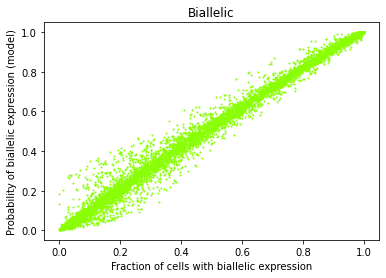

In [62]:
plt.title('Biallelic')
plt.scatter(expr_df['biallelic'], expr_df['p_biallelic'], s=1, c = '#89fe05')
plt.xlabel('Fraction of cells with biallelic expression')
plt.ylabel('Probability of biallelic expression (model)')
print(spearmanr(expr_df['biallelic'], expr_df['p_biallelic']))
plt.savefig('figures/Fig2A_2.svg')
plt.show()

SpearmanrResult(correlation=0.9577458665517686, pvalue=0.0)


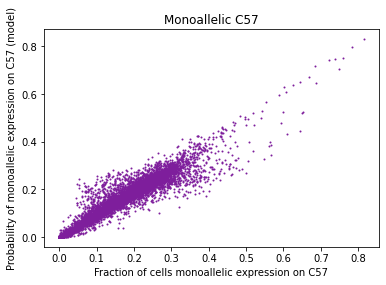

In [64]:
plt.title('Monoallelic C57')
plt.scatter(expr_df['mono_c57'], expr_df['p_mono_c57'], s=1, c ='#7e1e9c')
plt.xlabel('Fraction of cells monoallelic expression on C57')
plt.ylabel('Probability of monoallelic expression on C57 (model)')
print(spearmanr(expr_df['mono_c57'], expr_df['p_mono_c57']))
plt.savefig('figures/Fig2A_3.svg')
plt.show()

SpearmanrResult(correlation=0.9563265895861396, pvalue=0.0)


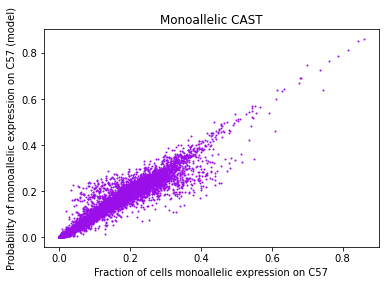

In [65]:
plt.title('Monoallelic CAST')
plt.scatter(expr_df['mono_cast'], expr_df['p_mono_cast'], s=1, c='#9a0eea')
plt.xlabel('Fraction of cells monoallelic expression on C57')
plt.ylabel('Probability of monoallelic expression on C57 (model)')
print(spearmanr(expr_df['mono_cast'], expr_df['p_mono_cast']))
plt.savefig('mono_cast_data_vs_prediction_fibr.svg')
plt.show()

In [36]:
bf_c57 = pd.Series(params.loc[common_idx].iloc[:,0], index=params.loc[common_idx].index)
bf_cast = pd.Series(params_cast.loc[common_idx].iloc[:,0], index=params_cast.loc[common_idx].index)
bf_c57 = bf_c57.reindex(expr_df.index)
bf_cast = bf_cast.reindex(expr_df.index)
bs_c57 = pd.Series(params.loc[common_idx].iloc[:,2]/params.loc[common_idx].iloc[:,1], index=params.loc[common_idx].index)
bs_cast = pd.Series(params_cast.loc[common_idx].iloc[:,2]/params_cast.loc[common_idx].iloc[:,1], index=params_cast.loc[common_idx].index)
bs_c57 = bs_c57.reindex(expr_df.index)
bs_cast = bs_cast.reindex(expr_df.index)

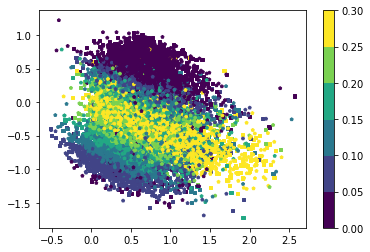

In [55]:
bounds = np.linspace(0,20,21)
plt.scatter(np.log10(bs_c57),np.log10(bf_c57),s=10, c=np.clip(expr_df['mono_c57'].reindex(bs_c57.index),0,0.3), cmap=plt.get_cmap('viridis', 6), marker='s')
plt.scatter(np.log10(bs_cast),np.log10(bf_cast),s=10, c=np.clip(expr_df['mono_cast'].reindex(bs_c57.index),0,0.3), cmap=plt.get_cmap('viridis', 6), marker='p')
plt.colorbar()
plt.savefig('Final_figures/Fig1E.pdf')

plt.show()

In [44]:
expr_df['mean_c57'] = UMI.mean(axis=1)
expr_df['mean_cast'] = UMI_cast.mean(axis=1)

In [57]:
expr_df.to_csv('S2_table.csv')

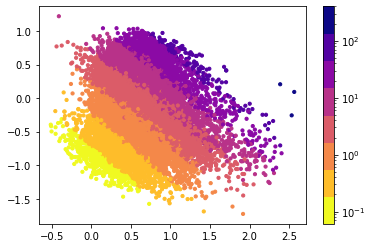

In [56]:
bounds = np.linspace(0,20,21)
plt.scatter(np.log10(bs_c57),np.log10(bf_c57),s=10,c=expr_df['mean_c57'], norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('plasma_r', 8))
plt.scatter(np.log10(bs_cast),np.log10(bf_cast),s=10,c=expr_df['mean_cast'], norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('plasma_r', 8))
plt.colorbar()
plt.savefig('Final_figures/Fig1B.pdf')

plt.show()

In [120]:
binwidth = 0.1
x_bins = np.arange(-1.2, 1.0, binwidth)

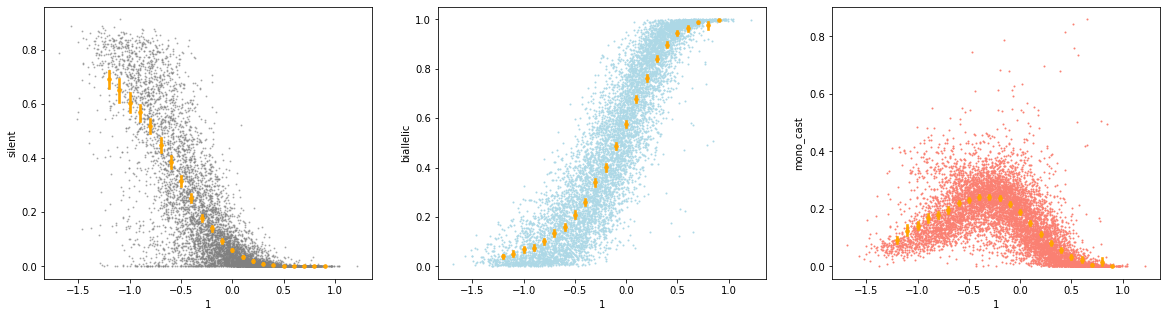

In [126]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(np.log10(bf_cast), expr_df['silent'], s=1, label='No Expression', c = 'gray', alpha=0.5)
sns.regplot(np.log10(bf_cast),expr_df['silent'], x_bins=x_bins, fit_reg=None, color='orange',marker='.')
plt.subplot(132)
plt.scatter(np.log10(bf_cast), expr_df['biallelic'], s=1, label='Biallelic expression',   c='lightblue')
sns.regplot(np.log10(bf_cast),expr_df['biallelic'], x_bins=x_bins, fit_reg=None, color='orange',marker='.')

plt.subplot(133)
plt.scatter(np.log10(bf_cast), expr_df['mono_cast'], s=1, label='Mono on CAST', c='salmon')# marker = 'p')
sns.regplot(np.log10(bf_cast),expr_df['mono_cast'], x_bins=x_bins, fit_reg=None, color='orange',marker='.')
plt.savefig('bf_scatters_and_lines.pdf')

plt.show()


In [130]:
binwidth = 0.1
x_bins = np.arange(0,2.0, binwidth)

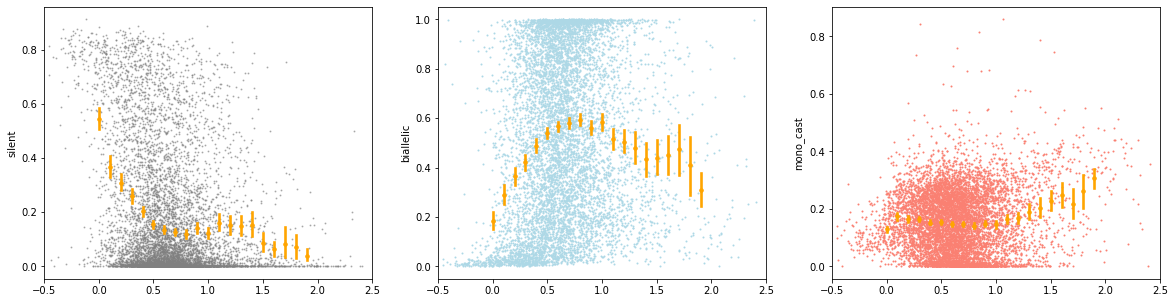

In [133]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(np.log10(bs_cast), expr_df['silent'], s=1, label='No Expression', c = 'gray', alpha=0.5)
sns.regplot(np.log10(bs_cast),expr_df['silent'], x_bins=x_bins, fit_reg=None, color='orange', marker='.')
plt.xlim((-0.5,2.5))

plt.subplot(132)
plt.scatter(np.log10(bs_cast), expr_df['biallelic'], s=1, label='Biallelic expression',   c='lightblue')
sns.regplot(np.log10(bs_cast),expr_df['biallelic'], x_bins=x_bins, fit_reg=None, color='orange', marker='.')
plt.xlim((-0.5,2.5))

plt.subplot(133)
plt.scatter(np.log10(bs_cast), expr_df['mono_cast'], s=1, label='Mono on CAST', c='salmon')
sns.regplot(np.log10(bs_cast),expr_df['mono_cast'], x_bins=x_bins, fit_reg=None, color='orange',marker='.')
plt.xlim((-0.5,2.5))
plt.savefig('bs_scatters_and_lines.pdf')
plt.show()

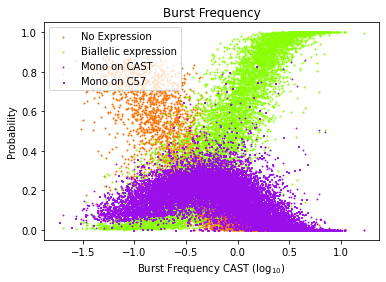

In [111]:
plt.title('Burst Frequency')
plt.scatter(np.log10(bf_cast), expr_df['p_silent'], s=1, label='No Expression', c = '#f97306')
plt.scatter(np.log10(bf_cast), expr_df['p_biallelic'], s=1, label='Biallelic expression',   c='#89fe05')
plt.scatter(np.log10(bf_cast), expr_df['p_mono_cast'], s=1, label='Mono on CAST', c='#9a0eea', marker='p')
plt.scatter(np.log10(bf_c57), expr_df['p_mono_c57'], s=1, label='Mono on C57', c='#9a0eea', marker='s')
plt.ylabel('Probability')
plt.xlabel(r'Burst Frequency CAST (log$_{10}$)')
plt.legend()
plt.savefig('Fig2Sup1a.svg')
plt.show()

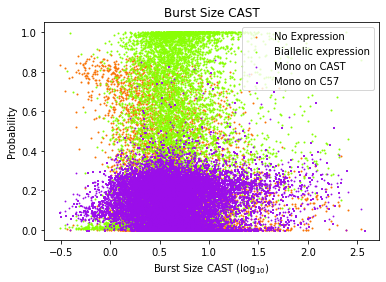

In [112]:
plt.title('Burst Size CAST')
plt.scatter(np.log10(bs_cast), expr_df['p_silent'], s=1, label='No Expression', c = '#f97306')
plt.scatter(np.log10(bs_cast), expr_df['p_biallelic'], s=1, label='Biallelic expression',   c='#89fe05')
plt.scatter(np.log10(bs_cast), expr_df['p_mono_cast'], s=1, label='Mono on CAST', c='#9a0eea', marker='p')
plt.scatter(np.log10(bs_c57), expr_df['p_mono_c57'], s=1, label='Mono on C57', c='#9a0eea', marker='s')
plt.ylabel('Probability')
plt.xlabel(r'Burst Size CAST (log$_{10}$)')
plt.legend()
plt.savefig('Fig2Sup1b.svg')
plt.show()

In [79]:
from patsy import dmatrices
from pygam import LinearGAM

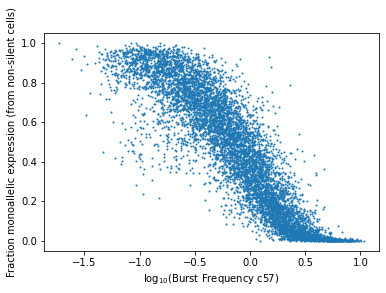

In [79]:
plt.scatter(np.log10(bf_c57), (expr_df['mono_c57']+expr_df['mono_cast'])/(1-expr_df['silent']), s=1)
plt.xlabel(r'log$_{10}$(Burst Frequency c57)')
plt.ylabel('Fraction monoallelic expression (from non-silent cells)')
plt.savefig('bf_vs_monoallelic_nonsilent_cells.pdf')
plt.show()

In [18]:
def LessThan(x,y):
    return x < y
def GreaterThan(x,y):
    return x > y
def Equal(x,y):
    return x == y

In [17]:
def getProb(dict1, dict2, fun):
    p = 0
    for counts, prob in dict1.items():
        p_cond = 0
        for counts2, prob2 in dict2.items():
            if fun(counts, counts2):
                p_cond += prob2
        p_cond *= prob
        p += p_cond
    return p

In [12]:
def allelicImbalance(params1, params2):
    par1_dict = dBP_dict(np.arange(np.rint(params1[2])),params1[0], params1[1], params1[2])
    par2_dict = dBP_dict(np.arange(np.rint(params2[2])),params2[0], params2[1], params2[2])
    p_gt = getProb(par1_dict, par2_dict, GreaterThan)
    p_lt = getProb(par1_dict, par2_dict, LessThan)
    p_eq = getProb(par1_dict, par2_dict, Equal)
    return p_gt, p_lt, p_eq

In [13]:
high_c57 = {}
high_cast = {}
equal_expr = {}
for gene in common_idx:
    c57 = UMI.loc[gene][pd.notnull(UMI.loc[gene])]
    cast = UMI_cast.loc[gene][pd.notnull(UMI_cast.loc[gene])]
    high_c57[gene] = np.mean(c57>cast)
    high_cast[gene] = np.mean(cast>c57)
    equal_expr[gene] = np.mean(c57==cast)

In [19]:
p_c57 = {}
p_cast = {}
p_equal = {}
for gene in common_idx:
    probs = allelicImbalance(params.loc[gene].values, params_cast.loc[gene].values)
    p_c57[gene] = probs[0]
    p_cast[gene] = probs[1]
    p_equal[gene] = probs[2]

In [20]:
AI_df = pd.DataFrame([high_c57, high_cast, equal_expr, p_c57, p_cast, p_equal], index=['high_c57', 'high_cast', 'equal', 'p_c57', 'p_cast', 'p_equal'])
AI_df.loc['p_imb'] = AI_df.loc['p_c57']+AI_df.loc['p_cast']
AI_df.loc['p_c57_norm'] = AI_df.loc['p_c57']/AI_df.loc['p_imb']
AI_df.loc['p_cast_norm'] = AI_df.loc['p_cast']/AI_df.loc['p_imb']
AI_df = AI_df.dropna(how='any', axis=1)

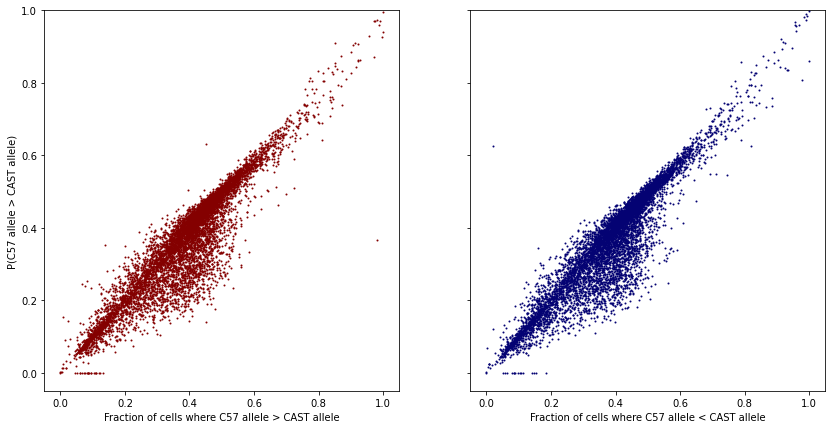

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(14,7))
AI_df.T.plot.scatter('high_c57', 'p_c57', s=1, c = '#840000', ax=ax1)
ax1.set_xlabel('Fraction of cells where C57 allele > CAST allele')
ax1.set_ylabel('P(C57 allele > CAST allele)')
ax1.set_ylim((-0.05,1))
AI_df.T.plot.scatter('high_cast', 'p_cast', s=1, c = '#040273', ax=ax2)
ax2.set_xlabel('Fraction of cells where C57 allele < CAST allele')
ax2.set_ylabel('P(C57 allele < CAST allele)')
#AI_df.T.plot.scatter('equal', 'p_equal', s=1)
#plt.xlabel('Fraction of cells where C57 allele = CAST allele')
#plt.ylabel('P(C57 allele = CAST allele)')
plt.savefig('Final_Figures_1st_submisson/Fig4a_011220.svg')
plt.show()

In [26]:
print(np.sum(AI_df.loc['p_c57_norm'] < 0.45))
print(np.sum(AI_df.loc['p_c57_norm'] > 0.55))

2169
2198


In [48]:
from scipy.stats import ttest_ind
t_test = {}
c57 = UMI.loc[gene][pd.notnull(UMI.loc[gene])]
cast = UMI_cast.loc[gene][pd.notnull(UMI_cast.loc[gene])]
t_test[gene] = ttest_ind(c57,cast).pvalue

In [49]:
AI_df.loc['t-test'] = np.log10(pd.Series(t_test))

In [50]:
AI_df.loc['bf_c57'] = np.log10(bf_c57)
AI_df.loc['bs_c57'] = np.log10(bs_c57)
AI_df.loc['bf_cast'] = np.log10(bf_cast)
AI_df.loc['bs_cast'] = np.log10(bs_cast)

In [51]:
AI_df.loc['bf_rel_diff'] = AI_df.loc['bf_c57']-AI_df.loc['bf_cast']
AI_df.loc['bs_rel_diff'] = AI_df.loc['bs_c57']-AI_df.loc['bs_cast']

In [52]:
AI_df.loc['rel_diff'] = np.log10(AI_df.loc['high_c57']/AI_df.loc['high_cast'])

/home/nbserver/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


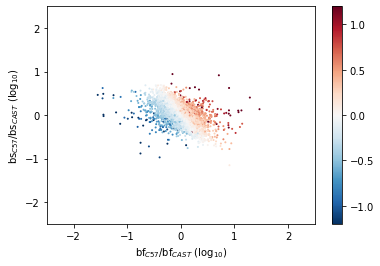

In [56]:
import matplotlib as mpl 
plt.scatter(np.log10(bf_c57.reindex(AI_df.columns)/bf_cast.reindex(AI_df.columns)), np.log10(bs_c57.reindex(AI_df.columns)/bs_cast.reindex(AI_df.columns)),c=AI_df.loc['rel_diff'],norm=mpl.colors.Normalize(vmin=-1.2, vmax=1.2),cmap=plt.get_cmap('RdBu_r'), s=1)
plt.xlabel('bf$_{C57}$/bf$_{CAST}$ (log$_{10}$)')
plt.ylabel('bs$_{C57}$/bs$_{CAST}$ (log$_{10}$)')
plt.xlim((-2.5,2.5))
plt.ylim((-2.5,2.5))
plt.colorbar()
plt.savefig('rel_bfbs_AI_color_011220.svg')
plt.show()

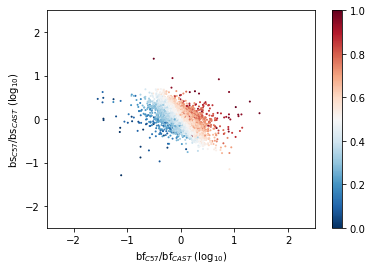

In [55]:
import matplotlib as mpl 
plt.scatter(np.log10(bf_c57.reindex(AI_df.columns)/bf_cast.reindex(AI_df.columns)), np.log10(bs_c57.reindex(AI_df.columns)/bs_cast.reindex(AI_df.columns)),c=AI_df.loc['high_c57']/(1-AI_df.loc['equal']),norm=mpl.colors.Normalize(vmin=0, vmax=1),cmap=plt.get_cmap('RdBu_r'), s=1)
plt.xlabel('bf$_{C57}$/bf$_{CAST}$ (log$_{10}$)')
plt.ylabel('bs$_{C57}$/bs$_{CAST}$ (log$_{10}$)')
plt.xlim((-2.5,2.5))
plt.ylim((-2.5,2.5))
plt.colorbar()
plt.savefig('Final_Figures_1st_submisson/Fig4b.svg')
plt.show()

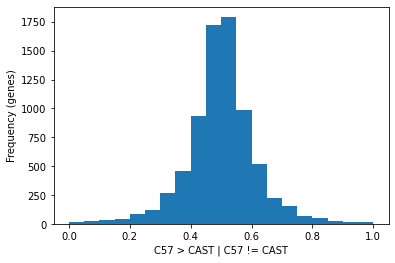

In [84]:
plt.hist(AI_df.loc['high_c57']/(1-AI_df.loc['equal']), bins=20)
plt.xlabel('C57 > CAST | C57 != CAST')
plt.ylabel('Frequency (genes)')
plt.savefig('Fig4Sup1a.svg')
plt.show()

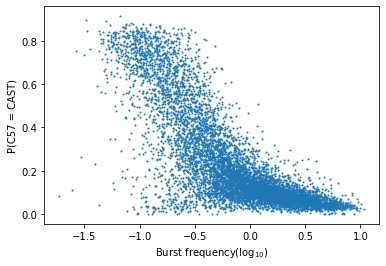

In [85]:
plt.scatter(np.log10(bf_c57.reindex(AI_df.columns)), AI_df.loc['equal'], s=1)
plt.xlabel('Burst frequency(log$_{10}$)')
plt.ylabel('P(C57 = CAST)')
plt.savefig('Fig4Sup1b.svg')
plt.show()

In [80]:
from patsy import dmatrices
import statsmodels.api as sm

In [90]:
AI_df = AI_df.drop('t-test')

In [92]:
AI_df2 = AI_df.dropna(how='any', axis=1)

In [94]:
AI_df2 = AI_df2.replace([np.inf, -np.inf], np.nan)

In [95]:
y,X = dmatrices('rel_diff ~ bf_rel_diff*bs_rel_diff', data = AI_df2.T, return_type='dataframe')


In [96]:
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}              &    rel\_diff     & \textbf{  R-squared:         } &      0.805   \\
\textbf{Model:}                      &       OLS        & \textbf{  Adj. R-squared:    } &      0.804   \\
\textbf{Method:}                     &  Least Squares   & \textbf{  F-statistic:       } &  1.042e+04   \\
\textbf{Date:}                       & Thu, 10 Dec 2020 & \textbf{  Prob (F-statistic):} &      0.00    \\
\textbf{Time:}                       &     13:39:14     & \textbf{  Log-Likelihood:    } &     5951.4   \\
\textbf{No. Observations:}           &        7600      & \textbf{  AIC:               } &  -1.189e+04  \\
\textbf{Df Residuals:}               &        7596      & \textbf{  BIC:               } &  -1.187e+04  \\
\textbf{Df Model:}                   &           3      & \textbf{                     } &              \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                                     & \textbf{

In [102]:
print('F test for bf_rel_diff = 0: ' + str(model.f_test('bf_rel_diff = 0')))
print('F test for bs_rel_diff = 0: ' + str(model.f_test('bs_rel_diff = 0')))
print('F test for bf_rel_diff:bs_rel_diff = 0: ' + str(model.f_test('bf_rel_diff:bs_rel_diff = 0')))
#print('F test for EPD_TATA = 0: ' + str(model.f_test('EPD_TATA = 0')))
#print('F test for gl:EPD_TATA = 0: ' + str(model.f_test('gl:EPD_TATA = 0')))
#print('F test for EPD_INR = 0: ' + str(model.f_test('EPD_INR = 0')))
#print('F test for EPD_TATA:EPD_INR = 0: ' + str(model.f_test('EPD_TATA:EPD_INR = 0')))

F test for bf_rel_diff = 0: <F test: F=array([[30663.24233806]]), p=0.0, df_denom=7.6e+03, df_num=1>
F test for bs_rel_diff = 0: <F test: F=array([[14546.43151176]]), p=0.0, df_denom=7.6e+03, df_num=1>
F test for bs_rel_diff = 0: <F test: F=array([[12.91269678]]), p=0.00032842684810205613, df_denom=7.6e+03, df_num=1>


In [97]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rel_diff   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                 1.042e+04
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        13:39:22   Log-Likelihood:                 5951.4
No. Observations:                7600   AIC:                        -1.189e+04
Df Residuals:                    7596   BIC:                        -1.187e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0017      0.001     -1.278      0.201      -0.004       0.001
bf_rel_diff                 1.2864      0.007    175.109      0.000       1.272       1.301
bs_rel_diff                 0.9272      0.008    120.609      0.000       0.912       0.942
bf_rel_diff:bs_rel_diff    -0.0740      0.021     -3.593      0.000      -0.114      -0.034
==============================================================================
Omnibus:                     5334.018   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2157308.955
Skew:                           2.175   Prob(JB):                         0.00
Kurtosis:                      85.424   Cond. No.                         16.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""